<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Подключаем все необходимые для выполнения проекта библиотеки:

In [114]:
import pandas as pd # обработка и анализ табличных данных

import nltk # обработка естественного языка
from nltk.corpus import stopwords as nltk_stopwords # применение стоп-слов
from nltk.corpus import wordnet # лемматизация c POS Tag
nltk.download("stopwords") # чтобы применить стоп-листы, их нужно предварительно скачать
nltk.download('wordnet') # лемматизация
nltk.download('averaged_perceptron_tagger') # лемматизация c POS Tag

import re # регулярные выражения

from sklearn.feature_extraction.text import TfidfVectorizer # создание признаков на основе слов

from sklearn.linear_model import LogisticRegression # модель линейной регрессии
from sklearn.ensemble import RandomForestClassifier # модель случайного леса

from sklearn.model_selection import train_test_split # выделение тестовой и обучающей выборок
from sklearn.model_selection import cross_val_score # кросс-валидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров для лучшей модели

from sklearn.metrics import f1_score # F1-мера
from sklearn.metrics import roc_curve # ROC-кривая
from sklearn.metrics import roc_auc_score # AUC-ROC

from sklearn.pipeline import Pipeline # конвейер преобразований

import seaborn as sns # построение графиков
import matplotlib.pyplot as plt # построение графиков

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Загружаем данные из текстового файла:

In [115]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

Выводим общую информацию о данных:

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Изучаем данные:

In [117]:
data.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим на дисбаланс классов:

In [106]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

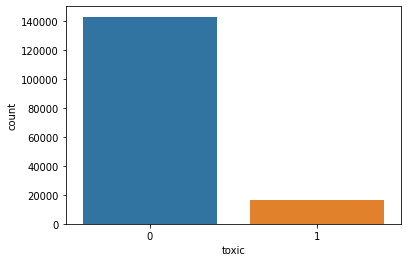

In [107]:
sns.countplot(data=data, x="toxic");

**Выводы**

В исходном наборе данных 159 292 размеченных текста. Наблюдается дисбаланс классов - текстов, размеченных как токсичные, в 9 раз меньше, чем нетоксичных - будем это учитывать при выделение обучающей и тестовой выборок и при построении моделей. Переходим к подготовке признаков.

Очищаем тексты от неалфавитных символов, выполняем токенизацию и лемматизацию, создаём корпус слов:

In [87]:
%%time

# Функция для определения правильного тэга для слова
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatize = nltk.WordNetLemmatizer()
new_text = []
for i in data.text:
    #удаляем неалфавитные символы
    text = re.sub("[^a-zA-Z]"," ",i) 
    # токенизируем слова
    text = nltk.word_tokenize(text,language = "english")
    # лемматирзируем слова
    text = [lemmatize.lemmatize(word, get_wordnet_pos(word)) for word in text]
    # соединяем слова
    text = " ".join(text)
    new_text.append(text)

CPU times: user 15min 42s, sys: 1min 33s, total: 17min 16s
Wall time: 17min 17s


'# Функция для определения правильного тэга для слова\ndef get_wordnet_pos(word):\n    tag = nltk.pos_tag([word])[0][1][0].upper()\n    tag_dict = {"J": wordnet.ADJ,\n                "N": wordnet.NOUN,\n                "V": wordnet.VERB,\n                "R": wordnet.ADV}\n    return tag_dict.get(tag, wordnet.NOUN)\n\nlemmatize = nltk.WordNetLemmatizer()\ndef get_prepared_text(source_text):\n    #удаляем неалфавитные символы\n    text = re.sub("[^a-zA-Z]"," ",source_text) \n    # токенизируем слова\n    text = nltk.word_tokenize(text,language = "english")\n    # лемматирзируем слова\n    text = [lemmatize.lemmatize(word, get_wordnet_pos(word)) for word in text]\n    # соединяем слова\n    text = "".join(text)\n\nnew_text = data[\'text\'].apply(get_prepared_text).tolist() \n'

Выделяем обучающую и тестовую выборки с учётом имеющегося дисбаланса классов (параметр stratify), предварительно отдельно выделяем целевой признак токсичности:

In [118]:
target = data['toxic'] # целевой признак

features_train, features_test, target_train, target_test = train_test_split(
    new_text, target, test_size=0.25, stratify = target, random_state=12345
)

Векторизовать тексты с помощью метода TF-IDF будем на этапе подбора гиперпараметров внутри Pipeline. Если сделать заранее - будет утечка признаков, так как GridSearchCV() использует кросс-валидацию.

## Обучение

Строим модель линейной регресии:

In [121]:
%%time

stopwords = set(nltk_stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords)
lr_model = LogisticRegression(class_weight = 'balanced', max_iter=10000)

pipeline = Pipeline(
    [
        ("tfidf", vectorizer),
        ("lr_model", lr_model),
    ]
)



param_grid = {
    "lr_model__C": range(5,15),
}
best_model_lr = GridSearchCV(pipeline, param_grid, scoring='f1')
best_model_lr.fit(features_train, target_train)
print(best_model_lr.best_params_)
print("Значение метрики F1 лучшей модели линейной регрессии:", best_model_lr.best_score_)

{'lr_model__C': 11}
Значение метрики F1 лучшей модели линейной регрессии: 0.7609729522320716
CPU times: user 4min 21s, sys: 8min 6s, total: 12min 28s
Wall time: 12min 29s


Строим модель случайного леса:

In [126]:
%%time


model_rf = RandomForestClassifier(class_weight = 'balanced', random_state=12345)

pipeline = Pipeline(
    [
        ("tfidf", vectorizer),
        ("model_rf", model_rf),
    ]
)

hyperparameters_rf = dict(model_rf__n_estimators=[50], model_rf__max_depth=[10])

gridsearch_rf = GridSearchCV(pipeline, hyperparameters_rf, scoring='f1')
best_model_rf = gridsearch_rf.fit(features_train, target_train)
print(best_model_rf.best_params_)
print("Значение метрики F1 лучшей модели случайного леса:", best_model_rf.best_score_)

{'model_rf__max_depth': 10, 'model_rf__n_estimators': 50}
Значение метрики F1 лучшей модели случайного леса: 0.3422440155668017
CPU times: user 41 s, sys: 139 ms, total: 41.1 s
Wall time: 41.2 s


**Выводы** 

На обучающей выборке наилучший результат показала модель линейной регрессии - F1-мера модели равна 0.76.

## Выводы

Векторизуем тексты с помощью метода TF-IDF (при подборе гиперпараметров этот этап был внутри пайплайна):

In [109]:
vectorizer.fit(features_train)

features_train = vectorizer.transform(features_train)
features_test = vectorizer.transform(features_test)

In [111]:
best_model = LogisticRegression(class_weight = 'balanced', C=11, max_iter=10000)

best_model.fit(features_train, target_train)
predictions_test = best_model.predict(features_test)

f1_bm = f1_score(target_test, predictions_test)

print('F1 наилучшей модели линейной регрессии на тестовой выборке', f1_bm)

F1 наилучшей модели линейной регрессии на тестовой выборке 0.7592485882217357


Строим ROC-кривую:

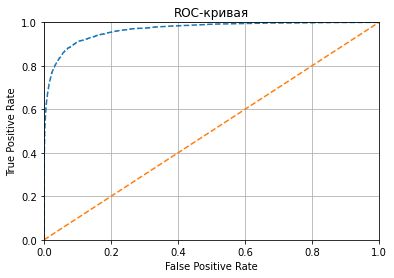

In [112]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr, linestyle='--')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.grid()
plt.show()

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, «площадь под ROC-кривой»):

In [113]:
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(auc_roc)

0.966384050368798


**Выводы**

На тестовой выборке F1-мера равна 0.76. Для модели, которая всегда отвечает случайно, ROC-кривая выглядит как прямая, идущая из левого нижнего угла в верхний правый,  AUC-ROC случайной модели равна 0.5. В нашем случае график выше, выше значение TPR и лучше качество модели, AUC-ROC составляет 0.97 - модель проходит проверку на адекватность (вменяемость).